In [1]:
# Dependencies
import json
import requests
from bs4 import BeautifulSoup as bs
import pymongo
import pandas as pd
from sqlalchemy import create_engine
import csv

In [2]:
# Initialize PyMongo to work with MongoDBs
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

In [3]:
# Define database and collection
db = client.etl_project_db
collection_oc = db.oc_data
collection_la = db.la_data
collection_city = db.city_zipcode
collection_income = db.income_data


In [4]:
# URL of page to be scraped

# Orange County: https://data-ocpw.opendata.arcgis.com/datasets/d625d46014c44e68a483ab0e74be2aa2_7/data
url_oc = 'https://opendata.arcgis.com/datasets/d625d46014c44e68a483ab0e74be2aa2_7.geojson'

# Los Angeles: https://data.lacity.org/dataset/2010-Census-Populations-by-Zip-Code/nxs9-385f/data
url_la = 'https://data.lacity.org/resource/nxs9-385f.json'

# California Zip Codes: https://www.zip-codes.com/state/ca.asp
url_city_data = 'https://www.zip-codes.com/state/ca.asp'


# CSV Data
csv_file_la_data = "Resources/LA_city_data.csv"
csv_file_income_data = "Resources/ca_agi.csv"

In [5]:
# CSV scraping
LA_data_df = pd.read_csv(csv_file_la_data)
ca_agi_df = pd.read_csv(csv_file_income_data)

In [6]:
# Cleaning LA Data: Dropping the "Median Age" and "Average Household Size" columns.
la_data_df = LA_data_df.drop(columns = ["Median Age", "Average Household Size"])
la_data_df.head()

,Zip Code,Total Population,Total Males,Total Females,Total Households
0,91371,1,0,1,1
1,90001,57110,28468,28642,12971
2,90002,51223,24876,26347,11731
3,90003,66266,32631,33635,15642
4,90004,62180,31302,30878,22547


In [7]:
# Cleaning LA Data: Dropping the first row.
la_data_df = la_data_df.drop(0)
la_data_df.head()

,Zip Code,Total Population,Total Males,Total Females,Total Households
1,90001,57110,28468,28642,12971
2,90002,51223,24876,26347,11731
3,90003,66266,32631,33635,15642
4,90004,62180,31302,30878,22547
5,90005,37681,19299,18382,15044


In [8]:
# Cleaning LA Data: Rename columns
la_data_df = la_data_df.rename(columns={"Zip Code": "zipcode", "Total Population": "total_population",
                          "Total Males":"male_population", "Total Females":"female_population",
                          "Total Households":"total_household"})

la_data_df.head()

,zipcode,total_population,male_population,female_population,total_household
1,90001,57110,28468,28642,12971
2,90002,51223,24876,26347,11731
3,90003,66266,32631,33635,15642
4,90004,62180,31302,30878,22547
5,90005,37681,19299,18382,15044


In [9]:
# Convert Zip Code data to String
la_data_df['zipcode'] = la_data_df.zipcode.astype(str)

In [10]:
# Insert LA Data to Mongo DB
data = la_data_df.to_dict(orient='records')
collection_la.insert_many(data)

In [11]:
# Cleaning Income Data: Selecting the null values of 'Unnamed: 1', null values which is the total AGI on 'Unnamed : 7'
ca_agi_zip_df = ca_agi_df[ca_agi_df['Unnamed: 1'].isnull()]
ca_agi_zip_df.head(10)

,CALIFORNIA,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70
0,Individual Income Tax Returns: \nSelected Inco...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[Money amounts are in thousands of dollars],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Number of returns,Amount,...,Number of returns,Amount,Number of returns,Amount,Number of returns,Amount,Number of returns,Amount,Number of returns,Amount
4,NaN,NaN,(1),(2),(3),(4),(5),(6),(7),(8),...,(60),(61),(62),(63),(64),(65),(66),(67),(68),(69)
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,90001,NaN,"20,342","4,877","16,680","53,836","23,654","492,447","17,343","421,322",...,41,172,"6,865","15,835","9,854","21,019","1,560","2,348","18,401","57,777"
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,90002,NaN,"18,126","3,682","14,105","46,213","20,375","438,935","15,191","371,484",...,21,20,"6,255","14,041","9,478","19,613","1,325","1,842","16,527","56,378"
28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,90003,NaN,"25,160","4,852","19,199","64,051","28,162","581,608","20,994","493,325",...,35,192,"8,099","17,794","12,604","25,313","1,989","2,541","22,799","75,872"


In [12]:
# Cleaning Income Data: Selecting 'CALIFORNIA', 'Unnamed: 7' columns.
ca_agi_zip_df = ca_agi_zip_df[['CALIFORNIA', 'Unnamed: 7']]
ca_agi_zip_df.head(10)

,CALIFORNIA,Unnamed: 7
0,Individual Income Tax Returns: \nSelected Inco...,NaN
1,[Money amounts are in thousands of dollars],NaN
3,NaN,NaN
4,NaN,(6)
12,NaN,NaN
13,90001,"492,447"
20,NaN,NaN
21,90002,"438,935"
28,NaN,NaN
29,90003,"581,608"


In [13]:
# Cleaning Income Data: Dropping NaN values
ca_agi_zip_df = ca_agi_zip_df.dropna()
ca_agi_zip_df.head(10)

,CALIFORNIA,Unnamed: 7
13,90001,"492,447"
21,90002,"438,935"
29,90003,"581,608"
37,90004,"1,451,721"
45,90005,"588,052"
53,90006,"514,937"
61,90007,"306,112"
69,90008,"624,166"
77,90010,"257,342"
85,90011,"808,914"


In [14]:
# Cleaning Income Data: Renaming the Column names.
ca_agi_zip_df = ca_agi_zip_df.rename(columns = {'CALIFORNIA':'zipcode', 'Unnamed: 7':'adjusted_gross_income' })
ca_agi_zip_df.head(10)


,zipcode,adjusted_gross_income
13,90001,"492,447"
21,90002,"438,935"
29,90003,"581,608"
37,90004,"1,451,721"
45,90005,"588,052"
53,90006,"514,937"
61,90007,"306,112"
69,90008,"624,166"
77,90010,"257,342"
85,90011,"808,914"


In [15]:
# Remove comma from string
ca_agi_zip_df['adjusted_gross_income'] = ca_agi_zip_df.adjusted_gross_income.str.replace(',', '')

In [16]:
# Convert AGI to Int
ca_agi_zip_df['adjusted_gross_income'] = ca_agi_zip_df.adjusted_gross_income.astype(int)

In [17]:
# Insert Income Data to Mongo DB
data_income = ca_agi_zip_df.to_dict(orient='records')
collection_income.insert_many(data_income)



<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN">

<html><head>
<title>Listing of all Zip Codes in the state of California</title>
<meta content="List of all Zip Codes for the state of California, CA. Includes all counties and cities in California." name="description"/>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="en-us" http-equiv="content-language"/>
<meta content="index,follow" name="robots"/>
<link href="https://www.zip-codes.com/state/ca.asp" rel="canonical"/>
<link href="https://www.zip-codes.com/m/state/ca.asp" media="only screen and (max-width: 640px)" rel="alternate"/>
<script async="" src="https://www.zip-codes.com/m/theme/ga/local-analytics.js"></script><script> window.dataLayer = window.dataLayer || [];function gtag(){dataLayer.push(arguments);}gtag('js', new Date());gtag('config', 'UA-23873959-1');</script><script async="async" src="https://www.googletagservices.com/tag/js/gpt.js"></script>
<script>
  var googletag = go
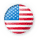

In [18]:
# Retrieve page with the requests module
response = requests.get(url_oc).json()
response_city = requests.get(url_city_data)

# Create BeautifulSoup object for scraping California Zip Codes'
soup = bs(response_city.text, 'html.parser')
print(soup)

In [19]:
# For loop to extract data from JSON for OC Data
for i in range(len(response['features'])):
    zipcode = response['features'][i]["properties"]["GEOID10"]
    total_population = response['features'][i]["properties"]["DP0010001"]
    male_population = response['features'][i]["properties"]["DP0010020"]
    female_population = response['features'][i]["properties"]["DP0010039"]
    total_household = response['features'][i]["properties"]["DP0130001"]
    
    post = {
        'zipcode':zipcode,
        'total_population':total_population,
        'male_population':male_population,
        'female_population':female_population,
        'total_household':total_household
    }
    
    # Dictionary to be inserted as a MongoDB document
    collection_oc.insert_one(post)

In [20]:
# Extract data for City Data
results = soup.find_all('tr')

print(results)

[<tr>
<td valign="top" width="195"><div class="side" id="side">
<div class="box"><div class="hd">Our Products</div><div class="cn">• <a href="/zip-code-database.asp" title="US ZIP Code Database">US ZIP Code Database</a><br/>• <a href="/zip-plus-4-database.asp" title="US ZIP Code Database">US ZIP+4 Database</a><br/>• <a href="/2010-census-database.asp" title="2010 Census Multi Level Database">2010 Census Database</a><br/>• <a href="/canadian-postal-code-database.asp" title="Canadian Database">Canadian Postal Codes</a><br/>• <a href="/map-boundary-data.asp" title="ZIP Code Boundary Data">ZIP Code Boundary Data</a><br/>• <a href="/zip-code-api.asp" title="ZIP Code API">ZIP Code API</a><span class="new"> NEW!</span><br/>• <a href="/area-code-database.asp" title="Area Code Database">Area Code Database</a><br/>• <a href="/zip-code-historical-database.asp" title="Historical Zip Codes">Historical Zip Codes</a><br/>• <a href="/zip-code-radius-app.asp" title="FREE Radius Application">FREE Radius

In [21]:
# For loop to insert data to Mongo for California City Data and ignore first column
row_num = 0
for result in results:
    if result.find('td'):
         if result.find_all('a'):
            if row_num>1:
                zipcode = result.find_all('a')[0].text.strip('ZIP Code ')
                city = result.find_all('a')[1].text
                post = {'zipcode':zipcode,
                        'city':city}
                # Dictionary to be inserted as a MongoDB document
                collection_city.insert_one(post)
            row_num = row_num + 1

In [22]:
# Display items in MongoDB collection
oc_data = db.oc_data.find()
city_data = db.city_zipcode.find()
la_data = db.la_data.find()
income_data = db.income_data.find()

In [23]:
for data in oc_data:
    print(data)

{'_id': ObjectId('5dd0a8a78dd50569ef1ac076'), 'zipcode': '90620', 'total_population': 45113, 'male_population': 22241, 'female_population': 22872, 'total_household': 13268}
{'_id': ObjectId('5dd0a8a78dd50569ef1ac077'), 'zipcode': '90621', 'total_population': 35153, 'male_population': 17377, 'female_population': 17776, 'total_household': 10304}
{'_id': ObjectId('5dd0a8a78dd50569ef1ac078'), 'zipcode': '90623', 'total_population': 15554, 'male_population': 7516, 'female_population': 8038, 'total_household': 5072}
{'_id': ObjectId('5dd0a8a78dd50569ef1ac079'), 'zipcode': '90630', 'total_population': 47993, 'male_population': 23204, 'female_population': 24789, 'total_household': 15785}
{'_id': ObjectId('5dd0a8a78dd50569ef1ac07a'), 'zipcode': '90631', 'total_population': 67619, 'male_population': 33320, 'female_population': 34299, 'total_household': 21452}
{'_id': ObjectId('5dd0a8a78dd50569ef1ac07b'), 'zipcode': '90680', 'total_population': 29945, 'male_population': 14811, 'female_population'

In [24]:
for data in la_data:
    print(data)

{'_id': ObjectId('5dd0a89b8dd50569ef1ab96a'), 'zipcode': '90001', 'total_population': 57110, 'male_population': 28468, 'female_population': 28642, 'total_household': 12971}
{'_id': ObjectId('5dd0a89b8dd50569ef1ab96b'), 'zipcode': '90002', 'total_population': 51223, 'male_population': 24876, 'female_population': 26347, 'total_household': 11731}
{'_id': ObjectId('5dd0a89b8dd50569ef1ab96c'), 'zipcode': '90003', 'total_population': 66266, 'male_population': 32631, 'female_population': 33635, 'total_household': 15642}
{'_id': ObjectId('5dd0a89b8dd50569ef1ab96d'), 'zipcode': '90004', 'total_population': 62180, 'male_population': 31302, 'female_population': 30878, 'total_household': 22547}
{'_id': ObjectId('5dd0a89b8dd50569ef1ab96e'), 'zipcode': '90005', 'total_population': 37681, 'male_population': 19299, 'female_population': 18382, 'total_household': 15044}
{'_id': ObjectId('5dd0a89b8dd50569ef1ab96f'), 'zipcode': '90006', 'total_population': 59185, 'male_population': 30254, 'female_populati

In [25]:
for data in city_data:
    print(data)

{'_id': ObjectId('5dd0a8aa8dd50569ef1ac0cf'), 'zipcode': '90001', 'city': 'Los Angeles'}
{'_id': ObjectId('5dd0a8aa8dd50569ef1ac0d0'), 'zipcode': '90002', 'city': 'Los Angeles'}
{'_id': ObjectId('5dd0a8aa8dd50569ef1ac0d1'), 'zipcode': '90003', 'city': 'Los Angeles'}
{'_id': ObjectId('5dd0a8aa8dd50569ef1ac0d2'), 'zipcode': '90004', 'city': 'Los Angeles'}
{'_id': ObjectId('5dd0a8aa8dd50569ef1ac0d3'), 'zipcode': '90005', 'city': 'Los Angeles'}
{'_id': ObjectId('5dd0a8aa8dd50569ef1ac0d4'), 'zipcode': '90006', 'city': 'Los Angeles'}
{'_id': ObjectId('5dd0a8aa8dd50569ef1ac0d5'), 'zipcode': '90007', 'city': 'Los Angeles'}
{'_id': ObjectId('5dd0a8aa8dd50569ef1ac0d6'), 'zipcode': '90008', 'city': 'Los Angeles'}
{'_id': ObjectId('5dd0a8aa8dd50569ef1ac0d7'), 'zipcode': '90009', 'city': 'Los Angeles'}
{'_id': ObjectId('5dd0a8aa8dd50569ef1ac0d8'), 'zipcode': '90010', 'city': 'Los Angeles'}
{'_id': ObjectId('5dd0a8aa8dd50569ef1ac0d9'), 'zipcode': '90011', 'city': 'Los Angeles'}
{'_id': ObjectId('5dd

{'_id': ObjectId('5dd0a8ab8dd50569ef1ac852'), 'zipcode': '95132', 'city': 'San Jose'}
{'_id': ObjectId('5dd0a8ab8dd50569ef1ac853'), 'zipcode': '95133', 'city': 'San Jose'}
{'_id': ObjectId('5dd0a8ab8dd50569ef1ac854'), 'zipcode': '95134', 'city': 'San Jose'}
{'_id': ObjectId('5dd0a8ab8dd50569ef1ac855'), 'zipcode': '95135', 'city': 'San Jose'}
{'_id': ObjectId('5dd0a8ab8dd50569ef1ac856'), 'zipcode': '95136', 'city': 'San Jose'}
{'_id': ObjectId('5dd0a8ab8dd50569ef1ac857'), 'zipcode': '95138', 'city': 'San Jose'}
{'_id': ObjectId('5dd0a8ab8dd50569ef1ac858'), 'zipcode': '95139', 'city': 'San Jose'}
{'_id': ObjectId('5dd0a8ab8dd50569ef1ac859'), 'zipcode': '95140', 'city': 'Mount Hamilton'}
{'_id': ObjectId('5dd0a8ab8dd50569ef1ac85a'), 'zipcode': '95141', 'city': 'San Jose'}
{'_id': ObjectId('5dd0a8ab8dd50569ef1ac85b'), 'zipcode': '95148', 'city': 'San Jose'}
{'_id': ObjectId('5dd0a8ab8dd50569ef1ac85c'), 'zipcode': '95150', 'city': 'San Jose'}
{'_id': ObjectId('5dd0a8ab8dd50569ef1ac85d'), 'z

In [26]:
for data in income_data:
    print(data)

{'_id': ObjectId('5dd0a8a38dd50569ef1abaa8'), 'zipcode': '90001', 'adjusted_gross_income': 492447}
{'_id': ObjectId('5dd0a8a38dd50569ef1abaa9'), 'zipcode': '90002', 'adjusted_gross_income': 438935}
{'_id': ObjectId('5dd0a8a38dd50569ef1abaaa'), 'zipcode': '90003', 'adjusted_gross_income': 581608}
{'_id': ObjectId('5dd0a8a38dd50569ef1abaab'), 'zipcode': '90004', 'adjusted_gross_income': 1451721}
{'_id': ObjectId('5dd0a8a38dd50569ef1abaac'), 'zipcode': '90005', 'adjusted_gross_income': 588052}
{'_id': ObjectId('5dd0a8a38dd50569ef1abaad'), 'zipcode': '90006', 'adjusted_gross_income': 514937}
{'_id': ObjectId('5dd0a8a38dd50569ef1abaae'), 'zipcode': '90007', 'adjusted_gross_income': 306112}
{'_id': ObjectId('5dd0a8a38dd50569ef1abaaf'), 'zipcode': '90008', 'adjusted_gross_income': 624166}
{'_id': ObjectId('5dd0a8a38dd50569ef1abab0'), 'zipcode': '90010', 'adjusted_gross_income': 257342}
{'_id': ObjectId('5dd0a8a38dd50569ef1abab1'), 'zipcode': '90011', 'adjusted_gross_income': 808914}
{'_id': O